Set Environment

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset

from torcheval.metrics.functional import multiclass_accuracy, multiclass_f1_score

Set Data Image

In [2]:
data_dir = './dataset'

transform = v2.Compose([
    v2.ToImage(),
    v2.Resize((224, 224)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(10),
    v2.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    v2.RandomAffine(degrees=5, translate=(0.1, 0.1)),
    v2.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(root=data_dir, transform=transform)

In [3]:
train_val_ds, test_ds = random_split(dataset, [0.8, 0.2])

train_ds, val_ds = random_split(train_val_ds, [0.75, 0.25])

print(f"Train set: {len(train_ds)} samples")
print(f"Valid set: {len(val_ds)} samples")
print(f"Test set: {len(test_ds)} samples")
print(f"Classes: {dataset.classes}")

Train set: 25077 samples
Valid set: 8358 samples
Test set: 8358 samples
Classes: ['Drowsy', 'Non Drowsy']


In [11]:
subset_train = Subset(train_ds, range(1000))
train_dl = DataLoader(subset_train, batch_size=128, shuffle=True, num_workers=4)
subset_val = Subset(val_ds, range(1000))
val_dl = DataLoader(subset_val, batch_size=128, shuffle=False)
subset_test = Subset(test_ds, range(1000))
test_dl = DataLoader(subset_test, batch_size=128, shuffle=False)

Train set


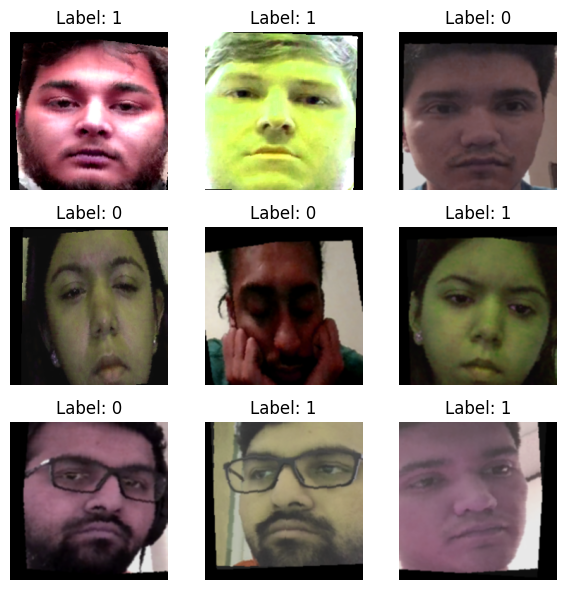

Valid set


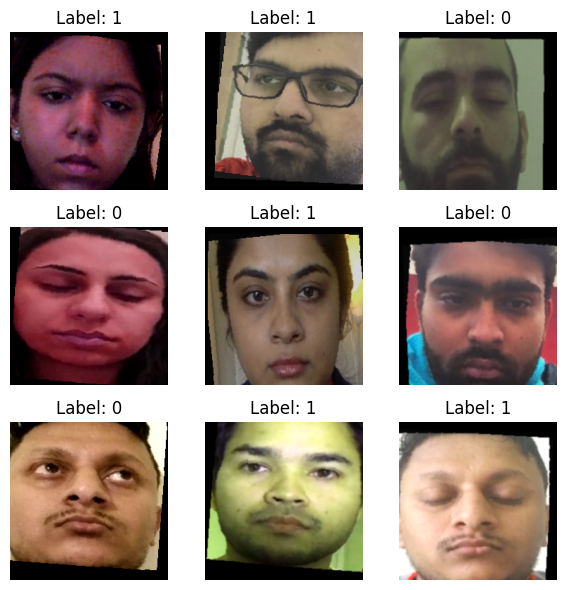

Test set


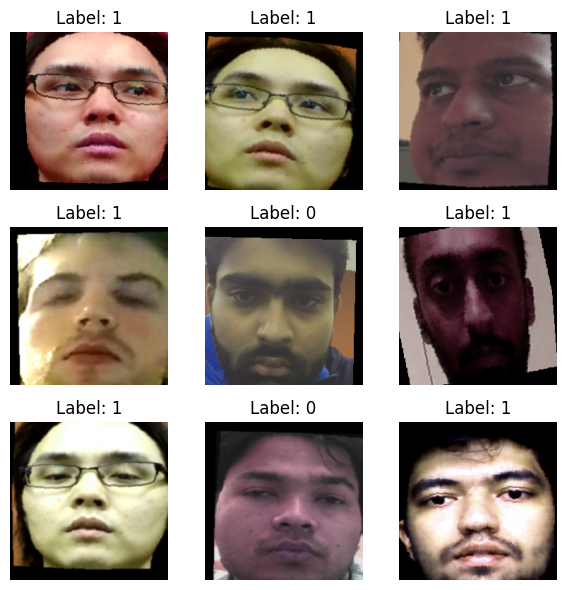

In [12]:
def plot_images_grid(dataloader, mean, std):
    for images, labels in dataloader:
        break
    _, axes = plt.subplots(3, 3, figsize=(6, 6))
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    for ax, image, label in zip(axes.flatten(), images, labels):            
        image = image * std + mean
        image = torch.clamp(image, 0, 1)
        image = image.permute(1, 2, 0)  # Change the order of dimensions to (H, W, C)
        ax.imshow(image)
        ax.set_title(f"Label: {label.item()}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
print("Train set"); plot_images_grid(train_dl, mean, std);
print("Valid set"); plot_images_grid(val_dl, mean, std);
print("Test set"); plot_images_grid(test_dl, mean, std);

Model Set Up

In [13]:

import torch.nn as nn
import torchvision.models as models

# Load pre-trained ResNet50 model
model = models.resnet50(pretrained=True)

# Modify the final fully connected layer
num_classes = 2  # Replace with the actual number of classes in your dataset
model.fc = nn.Linear(model.fc.in_features, num_classes)

criterion = nn.CrossEntropyLoss()

c:\Users\VN\anaconda3\envs\itcs498\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\VN\anaconda3\envs\itcs498\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Utils Set Up

In [14]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return total_loss / total, correct / total


In [15]:
def plot_predictions(images, labels, predictions, class_names):
    images = images.cpu()
    labels = labels.cpu()
    predictions = predictions.cpu()
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for idx, ax in enumerate(axes):
        img = images[idx].permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.set_title(f"True: {class_names[labels[idx]]}\nPred: {class_names[predictions[idx]]}")
        ax.axis('off')
    plt.show()


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm

def train_model(model, train_loader, val_loader, device, epochs=10, lr=1e-4):
    # Set loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_val_acc = 0.0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        model.train()
        train_loss, correct, total = 0.0, 0, 0

        # train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        # val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = train_loss / total
        train_acc = correct / total

        # Validation
        val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)

        print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_model.pth")
            print("✅ Best model saved!")

    print("Training complete.")
    return model

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    return val_loss / total, correct / total


In [17]:
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.to(device)

trained_model = train_model(model, train_dl, val_dl, device, epochs=10)


Epoch 1/10


Training: 100%|██████████| 8/8 [05:57<00:00, 44.69s/it]


Train Loss: 0.5488, Train Acc: 0.7300
Val   Loss: 0.3745, Val   Acc: 0.8190
✅ Best model saved!

Epoch 2/10


Training: 100%|██████████| 8/8 [06:21<00:00, 47.71s/it]


Train Loss: 0.1771, Train Acc: 0.9510
Val   Loss: 0.1640, Val   Acc: 0.9430
✅ Best model saved!

Epoch 3/10


Training: 100%|██████████| 8/8 [06:12<00:00, 46.52s/it]


Train Loss: 0.0646, Train Acc: 0.9730
Val   Loss: 0.1149, Val   Acc: 0.9600
✅ Best model saved!

Epoch 4/10


Training: 100%|██████████| 8/8 [05:59<00:00, 44.95s/it]


Train Loss: 0.0451, Train Acc: 0.9860
Val   Loss: 0.1083, Val   Acc: 0.9590

Epoch 5/10


Training: 100%|██████████| 8/8 [06:00<00:00, 45.05s/it]


Train Loss: 0.0282, Train Acc: 0.9890
Val   Loss: 0.0319, Val   Acc: 0.9890
✅ Best model saved!

Epoch 6/10


Training: 100%|██████████| 8/8 [06:04<00:00, 45.61s/it]


Train Loss: 0.0168, Train Acc: 0.9930
Val   Loss: 0.0522, Val   Acc: 0.9820

Epoch 7/10


Training: 100%|██████████| 8/8 [05:48<00:00, 43.56s/it]


Train Loss: 0.0212, Train Acc: 0.9940
Val   Loss: 0.0251, Val   Acc: 0.9890

Epoch 8/10


Training: 100%|██████████| 8/8 [05:53<00:00, 44.16s/it]


Train Loss: 0.0132, Train Acc: 0.9950
Val   Loss: 0.0321, Val   Acc: 0.9890

Epoch 9/10


Training: 100%|██████████| 8/8 [06:05<00:00, 45.70s/it]


Train Loss: 0.0158, Train Acc: 0.9950
Val   Loss: 0.0083, Val   Acc: 0.9970
✅ Best model saved!

Epoch 10/10


Training: 100%|██████████| 8/8 [05:54<00:00, 44.34s/it]


Train Loss: 0.0148, Train Acc: 0.9950
Val   Loss: 0.0250, Val   Acc: 0.9920
Training complete.
